In [2]:
import os
import torch
import copy
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet_v2.features
        for param in self.features.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        return self.features(x)

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_type='batchnorm', apply_dropout=False):
        super(UpSampleBlock, self).__init__()
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if norm_type.lower() == 'batchnorm':
            layers.append(nn.BatchNorm2d(out_channels))
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU(inplace=True))
        self.upsample = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.upsample(x)




In [3]:
class MobileNetV2_UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            UpSampleBlock(1280, 512, apply_dropout=True),
            UpSampleBlock(512, 256),
            UpSampleBlock(256, 128),
            UpSampleBlock(128, 64),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # 출력 크기 조정
        x = F.interpolate(x, size=(960, 544), mode='bilinear', align_corners=False)
        return x
    


In [4]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import numpy as np
from PIL import Image
import torch

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((960, 544))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, mask):
        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        # 마스크는 크기만 조정하고, 텐서로 변환합니다. Normalize는 적용하지 않습니다.
        mask = self.resize(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        return image, mask
    
# 데이터셋 정의
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask



In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
from torchvision import transforms



# 데이터셋 및 DataLoader 설정
resize_transform = transforms.Compose([
    transforms.Resize((960, 544)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RoadSegmentationDataset(
    image_dir='/home/ksy/WorkData/segmentation/trainImage',
    mask_dir='/home/ksy/WorkData/segmentation/trainLabels',
    transform=CustomTransform()  # CustomTransform 인스턴스로 수정
)

val_dataset = RoadSegmentationDataset(
    image_dir='/home/ksy/WorkData/segmentation/verification',
    mask_dir='/home/ksy/WorkData/segmentation/verificationLabel',
    transform=CustomTransform()  # CustomTransform 인스턴스로 수정
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# 모델, 손실 함수 및 최적화 알고리즘 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2_UNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    
    # 검증 과정
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # 모델 저장
    if val_loss < best_loss:
        print(f'Validation loss decreased from {best_loss:.4f} to {val_loss:.4f}. Saving model...')
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

# 학습 완료 후, 최적 모델 가중치를 로드
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'best_model5.pth')


Epoch 1/50, Train Loss: 0.6483, Validation Loss: 0.4735
Validation loss decreased from inf to 0.4735. Saving model...
Epoch 2/50, Train Loss: 0.4416, Validation Loss: 0.4627
Validation loss decreased from 0.4735 to 0.4627. Saving model...
Epoch 3/50, Train Loss: 0.4045, Validation Loss: 0.4602
Validation loss decreased from 0.4627 to 0.4602. Saving model...
Epoch 4/50, Train Loss: 0.3805, Validation Loss: 0.5080
Epoch 5/50, Train Loss: 0.3417, Validation Loss: 0.4362
Validation loss decreased from 0.4602 to 0.4362. Saving model...
Epoch 6/50, Train Loss: 0.3347, Validation Loss: 0.4278
Validation loss decreased from 0.4362 to 0.4278. Saving model...
Epoch 7/50, Train Loss: 0.3144, Validation Loss: 0.4141
Validation loss decreased from 0.4278 to 0.4141. Saving model...
Epoch 8/50, Train Loss: 0.3057, Validation Loss: 0.5002
Epoch 9/50, Train Loss: 0.2969, Validation Loss: 0.5078
Epoch 10/50, Train Loss: 0.2829, Validation Loss: 0.4371
Epoch 11/50, Train Loss: 0.2675, Validation Loss: 0.

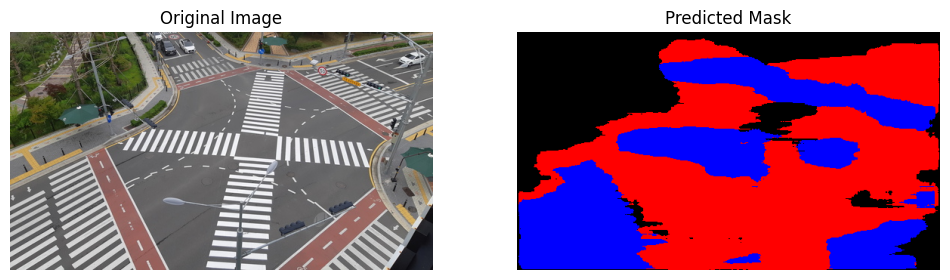

In [56]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def mask_to_color_image(mask):
    """예측된 마스크를 색상 이미지로 변환합니다."""
    # 클래스별 색상 정의: 0 - 검정, 1 - 빨강, 2 - 파랑, 3 - 노랑
    colors = torch.tensor([
        [0, 0, 0],       # 검정
        [255, 0, 0],     # 빨강
        [0, 0, 255],     # 파랑
        [255, 255, 0]    # 노랑
    ], dtype=torch.uint8)

    # 예측된 마스크의 각 픽셀에 대응하는 색상으로 변환
    color_mask = torch.zeros((mask.size(0), mask.size(1), 3), dtype=torch.uint8)
    for class_idx in range(4):
        color_mask[mask == class_idx] = colors[class_idx]

    return color_mask


def visualize_prediction_with_image(model, image_path, device='cpu'):
    # 이미지 전처리 및 모델을 통한 예측
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((960, 544)),  # 모델 입력 크기에 맞춰 조정 (필요에 따라 조정)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # 모델 예측
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.to(device))
        # 출력 크기를 원본 이미지 크기로 조정
        output = F.interpolate(output, size=image.size[::-1], mode='bilinear', align_corners=False)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # 예측된 마스크

   # 원본 이미지 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 예측된 마스크를 색상 이미지로 변환
    color_mask = mask_to_color_image(predicted_mask.cpu())

    # 예측된 색상 마스크 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# 모델을 CPU나 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 가중치 로드 (학습된 모델 가중치 경로 지정 필요)
model.load_state_dict(torch.load('/home/ksy/Workspace/best_model.pth', map_location=device))

# 시각화 실행
image_path = '/home/ksy/WorkData/test/Test2.jpg'  # 시각화할 이미지 경로
visualize_prediction_with_image(model, image_path, device)


In [57]:
def calculate_iou(pred, target, n_classes=4):
    iou_list = []
    pred = torch.argmax(pred, dim=1).flatten()
    target = target.flatten()
    
    for cls in range(n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()  # True Positive
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # TP + FP + FN
        if union == 0:
            iou_list.append(float('nan'))  # 클래스가 데이터셋에 존재하지 않는 경우
        else:
            iou_list.append(float(intersection) / float(max(union, 1)))
    return iou_list

def calculate_f1(pred, target, n_classes=4):
    f1_list = []
    pred = torch.argmax(pred, dim=1).flatten()
    target = target.flatten()
    
    for cls in range(n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        tp = (pred_inds[target_inds]).long().sum().item()
        fp = (pred_inds[~target_inds]).long().sum().item()
        fn = (~pred_inds[target_inds]).long().sum().item()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_list.append(f1)
    return f1_list


In [59]:
model.eval()
iou_scores = []
f1_scores = []
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        
        # IoU와 F1 점수 계산
        ious = calculate_iou(outputs, masks, n_classes=4)
        f1s = calculate_f1(outputs, masks, n_classes=4)
        
        iou_scores.append(ious)
        f1_scores.append(f1s)

# 평균 IoU와 F1 점수를 계산
avg_iou = torch.tensor(iou_scores).nanmean().item()
avg_f1 = torch.tensor(f1_scores).mean().item()

print(f'Average IoU: {avg_iou:.4f}, Average F1 Score: {avg_f1:.4f}')


Average IoU: 0.4850, Average F1 Score: 0.5400


In [63]:
import os
import torch
import copy
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet_v2.features
        for param in self.features.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        return self.features(x)

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_type='batchnorm', apply_dropout=False):
        super(UpSampleBlock, self).__init__()
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if norm_type.lower() == 'batchnorm':
            layers.append(nn.BatchNorm2d(out_channels))
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU(inplace=True))
        self.upsample = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.upsample(x)

class MobileNetV2_UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            UpSampleBlock(1280, 512, apply_dropout=True),
            UpSampleBlock(512, 256),
            UpSampleBlock(256, 128),
            UpSampleBlock(128, 64),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # 출력 크기 조정
        x = F.interpolate(x, size=(960, 544), mode='bilinear', align_corners=False)
        return x
    
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import numpy as np
from PIL import Image
import torch

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((960, 544))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, mask):
        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        # 마스크는 크기만 조정하고, 텐서로 변환합니다. Normalize는 적용하지 않습니다.
        mask = self.resize(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        return image, mask
    
# 데이터셋 정의
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
from torchvision import transforms



# 모델 성능 평가를 위한 함수 정의
def evaluate_metrics(outputs, labels, num_classes):
    pred_flat = outputs.argmax(1).view(-1)
    labels_flat = labels.view(-1)
    precision = precision_score(labels_flat.cpu(), pred_flat.cpu(), average='macro', zero_division=0)
    recall = recall_score(labels_flat.cpu(), pred_flat.cpu(), average='macro', zero_division=0)
    f1 = f1_score(labels_flat.cpu(), pred_flat.cpu(), average='macro', zero_division=0)
    return precision, recall, f1

# 데이터셋 및 DataLoader 설정
train_dataset = RoadSegmentationDataset(
    # ...
)
val_dataset = RoadSegmentationDataset(
    # ...
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# 모델, 손실 함수 및 최적화 알고리즘 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2_UNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ... [Previous code for model, dataset, and dataloaders]

# Initialize metrics storage
train_losses, val_losses = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

# Training and validation
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    all_train_precisions, all_train_recalls, all_train_f1s = [], [], []
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        
        # Calculate precision, recall, f1 for the current batch
        precision, recall, f1 = evaluate_metrics(outputs, masks, num_classes=4)
        all_train_precisions.append(precision)
        all_train_recalls.append(recall)
        all_train_f1s.append(f1)

    # Average metrics for this epoch
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_precision = np.mean(all_train_precisions)
    epoch_train_recall = np.mean(all_train_recalls)
    epoch_train_f1 = np.mean(all_train_f1s)
    
    train_losses.append(epoch_train_loss)
    train_precisions.append(epoch_train_precision)
    train_recalls.append(epoch_train_recall)
    train_f1s.append(epoch_train_f1)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_precisions, all_val_recalls, all_val_f1s = [], [], []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

            # Calculate precision, recall, f1 for the current batch
            precision, recall, f1 = evaluate_metrics(outputs, masks, num_classes=4)
            all_val_precisions.append(precision)
            all_val_recalls.append(recall)
            all_val_f1s.append(f1)

    # Average metrics for this epoch
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_precision = np.mean(all_val_precisions)
    epoch_val_recall = np.mean(all_val_recalls)
    epoch_val_f1 = np.mean(all_val_f1s)

    val_losses.append(epoch_val_loss)
    val_precisions.append(epoch_val_precision)
    val_recalls.append(epoch_val_recall)
    val_f1s.append(epoch_val_f1)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f}, Precision: {epoch_train_precision:.4f}, Recall: {epoch_train_recall:.4f}, F1: {epoch_train_f1:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f}, Precision: {epoch_val_precision:.4f}, Recall: {epoch_val_recall:.4f}, F1: {epoch_val_f1:.4f}')

    # Save the model if the validation loss has decreased
    if epoch_val_loss < best_loss:
        print(f'Saving model (epoch {epoch+1}): Val Loss improved from {best_loss:.4f} to {epoch_val_loss:.4f}')
        best_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'best_model.pth')

# Plot metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.title('Precision')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.title('Recall')
plt.legend()


/home/ksy/anaconda3/envs/unetnet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ksy/anaconda3/envs/unetnet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6834, Validation Loss: 0.4695


AttributeError: 'int' object has no attribute 'append'